In [2]:
# some_file.py
import sys

# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, "/Users/dhruvbalwada/work_root/sogos/")

In [3]:
import os
from numpy import *
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds

In [5]:
import sogos.download_product as dlp
import sogos.load_product as ldp
import sogos.time_tools as tt
import sogos.geo_tools as gt
import sogos.download_file as df

In [6]:
import gsw
import cmocean as cmocean

# Download Latest Data

In [7]:
data_dir = "/Users/dhruvbalwada/work_root/sogos/data/raw/climatology/"

FTP ADDRESS: ftp://kakapo.ucsd.edu/pub/gilson/argo_climatology/

Data prior to 2017 (till Dec 2016) is in a single file 

In [8]:
# download the big climatology files
wget.download(
    "ftp://kakapo.ucsd.edu/pub/gilson/argo_climatology/RG_ArgoClim_Salinity_2017.nc.gz",
    data_dir,
)
wget.download(
    "ftp://kakapo.ucsd.edu/pub/gilson/argo_climatology/RG_ArgoClim_Temperature_2017.nc.gz",
    data_dir,
)

NameError: name 'wget' is not defined

In [44]:
from ftplib import FTP

In [7]:
ftp_address = "ftp://kakapo.ucsd.edu/pub/gilson/argo_climatology/RG_ArgoClim_2019"

In [45]:
url_root = "/pub/gilson/argo_climatology/"
ftp_root = "kakapo.ucsd.edu"

In [49]:
ftp = FTP(ftp_root)
ftp.login()
ftp.cwd(url_root)
contents = ftp.nlst("RG_ArgoClim_2017*")

In [58]:
contents = ftp.nlst("RG_ArgoClim_201*")

In [61]:
for i in contents:
    print("Downloading" + i)
    wget.download("ftp://kakapo.ucsd.edu/pub/gilson/argo_climatology/" + i, data_dir)

DownloadingRG_ArgoClim_201701.nc.gz
DownloadingRG_ArgoClim_201702.nc.gz
DownloadingRG_ArgoClim_201703.nc.gz
DownloadingRG_ArgoClim_201704.nc.gz
DownloadingRG_ArgoClim_201705.nc.gz
DownloadingRG_ArgoClim_201706.nc.gz
DownloadingRG_ArgoClim_201707.nc.gz
DownloadingRG_ArgoClim_201708.nc.gz
DownloadingRG_ArgoClim_201709.nc.gz
DownloadingRG_ArgoClim_201710.nc.gz
DownloadingRG_ArgoClim_201711.nc.gz
DownloadingRG_ArgoClim_201712.nc.gz
DownloadingRG_ArgoClim_201801.nc.gz
DownloadingRG_ArgoClim_201802.nc.gz
DownloadingRG_ArgoClim_201803.nc.gz
DownloadingRG_ArgoClim_201804.nc.gz
DownloadingRG_ArgoClim_201805.nc.gz
DownloadingRG_ArgoClim_201806.nc.gz
DownloadingRG_ArgoClim_201807.nc.gz
DownloadingRG_ArgoClim_201808.nc.gz
DownloadingRG_ArgoClim_201809.nc.gz
DownloadingRG_ArgoClim_201810.nc.gz
DownloadingRG_ArgoClim_201811.nc.gz
DownloadingRG_ArgoClim_201812.nc.gz
DownloadingRG_ArgoClim_201901.nc.gz
DownloadingRG_ArgoClim_201902.nc.gz
DownloadingRG_ArgoClim_201903.nc.gz
DownloadingRG_ArgoClim_20190

## Load some data 

In [9]:
Tclim = xr.open_dataset(data_dir + "RG_ArgoClim_Temperature_2017.nc", decode_times=False)
Sclim = xr.open_dataset(data_dir + "RG_ArgoClim_Salinity_2017.nc", decode_times=False)

In [10]:
Climextra = xr.open_mfdataset(data_dir+ 'RG_ArgoClim_201*', decode_times=False)

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [11]:
RG_clim = xr.merge([Tclim, Sclim, Climextra])

In [13]:
# Calendar type was missing, and giving errors in decoding time
RG_clim.TIME.attrs['calendar'] = '360_day'
RG_clim = xr.decode_cf(RG_clim)

In [14]:
## Add density and other things 
SA = xr.apply_ufunc(gsw.SA_from_SP, RG_clim.ARGO_SALINITY_MEAN+RG_clim.ARGO_SALINITY_ANOMALY, RG_clim.PRESSURE , 
                                    RG_clim.LONGITUDE, RG_clim.LATITUDE,
                    dask='parallelized', output_dtypes=[float,]).rename('SA')
CT = xr.apply_ufunc(gsw.CT_from_t, SA, RG_clim.ARGO_TEMPERATURE_MEAN+RG_clim.ARGO_SALINITY_ANOMALY, RG_clim.PRESSURE, 
                     dask='parallelized', output_dtypes=[float,]).rename('CT')
SIGMA0 = xr.apply_ufunc(gsw.sigma0, SA, CT, dask='parallelized', output_dtypes=[float,]).rename('SIGMA0')

In [15]:
RG_clim = xr.merge([RG_clim, SIGMA0])

In [17]:
T_region = RG_clim.ARGO_TEMPERATURE_ANOMALY.groupby('TIME.season').mean() + RG_clim.ARGO_TEMPERATURE_MEAN
S_region = RG_clim.ARGO_SALINITY_ANOMALY.groupby('TIME.season').mean() + RG_clim.ARGO_SALINITY_MEAN
rho_region = RG_clim.SIGMA0.groupby('TIME.season').mean()

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/so

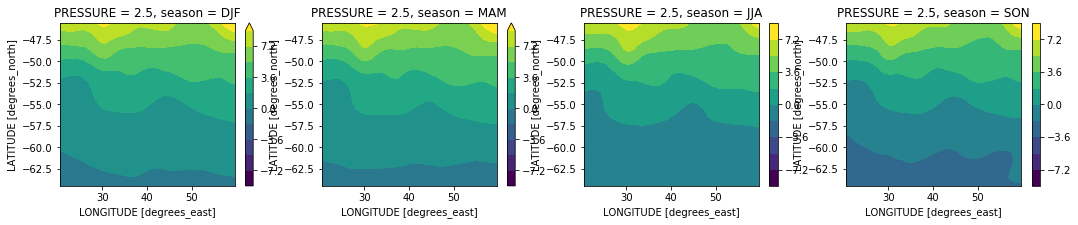

In [18]:
plt.figure(figsize=(18,3))
plt.subplot(141)
T_region.sel(LATITUDE=slice(-65,-45), LONGITUDE=slice(20,60)).isel(PRESSURE=0).sel(season='DJF').plot.contourf(levels=11, vmin=-9, vmax=9);

plt.subplot(142)
T_region.sel(LATITUDE=slice(-65,-45), LONGITUDE=slice(20,60)).isel(PRESSURE=0).sel(season='MAM').plot.contourf(levels=11, vmin=-9, vmax=9);

plt.subplot(143)
T_region.sel(LATITUDE=slice(-65,-45), LONGITUDE=slice(20,60)).isel(PRESSURE=0).sel(season='JJA').plot.contourf(levels=11, vmin=-9, vmax=9);

plt.subplot(144)
T_region.sel(LATITUDE=slice(-65,-45), LONGITUDE=slice(20,60)).isel(PRESSURE=0).sel(season='SON').plot.contourf(levels=11, vmin=-9, vmax=9);

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/so

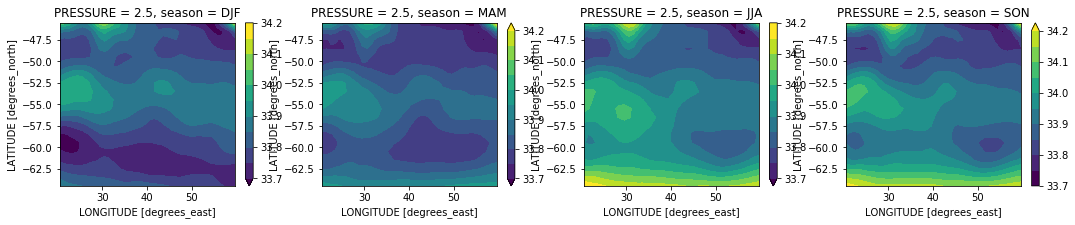

In [160]:
plt.figure(figsize=(18,3))
plt.subplot(141)
S_region.sel(LATITUDE=slice(-65,-45), LONGITUDE=slice(20,60)).isel(PRESSURE=0).sel(season='DJF').plot.contourf(levels=11, vmin=33.7, vmax=34.2)

plt.subplot(142)
S_region.sel(LATITUDE=slice(-65,-45), LONGITUDE=slice(20,60)).isel(PRESSURE=0).sel(season='MAM').plot.contourf(levels=11, vmin=33.7, vmax=34.2)

plt.subplot(143)
S_region.sel(LATITUDE=slice(-65,-45), LONGITUDE=slice(20,60)).isel(PRESSURE=0).sel(season='JJA').plot.contourf(levels=11, vmin=33.7, vmax=34.2)

plt.subplot(144)
S_region.sel(LATITUDE=slice(-65,-45), LONGITUDE=slice(20,60)).isel(PRESSURE=0).sel(season='SON').plot.contourf(levels=11, vmin=33.7, vmax=34.2)
plt.tight_layoutout()

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/so

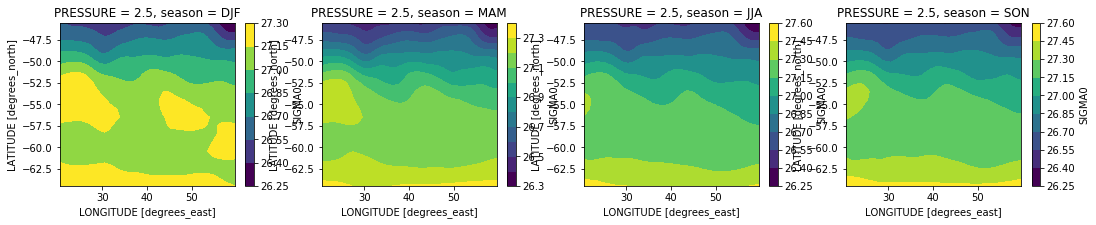

In [158]:
plt.figure(figsize=(18,3))
plt.subplot(141)
rho_region.sel(LATITUDE=slice(-65,-45), LONGITUDE=slice(20,60)).isel(PRESSURE=0).sel(season='DJF').plot.contourf(levels=11)

plt.subplot(142)
rho_region.sel(LATITUDE=slice(-65,-45), LONGITUDE=slice(20,60)).isel(PRESSURE=0).sel(season='MAM').plot.contourf(levels=11)

plt.subplot(143)
rho_region.sel(LATITUDE=slice(-65,-45), LONGITUDE=slice(20,60)).isel(PRESSURE=0).sel(season='JJA').plot.contourf(levels=11)

plt.subplot(144)
rho_region.sel(LATITUDE=slice(-65,-45), LONGITUDE=slice(20,60)).isel(PRESSURE=0).sel(season='SON').plot.contourf(levels=11)

### Some Climatological Mean Sections 

In [19]:
dens_section30 = RG_clim.SIGMA0.sel(LONGITUDE=30, method='nearest').sel(LATITUDE=slice(-70,-40)).load()
dens_section40 = RG_clim.SIGMA0.sel(LONGITUDE=40, method='nearest').sel(LATITUDE=slice(-70,-40)).load()

In [20]:
glider = {"start_month": 4.99, "end_month":7.8,  "start_lat": -51.5, "end_lat": -53, "max_depth": 1000}

NameError: name 'dens_section' is not defined

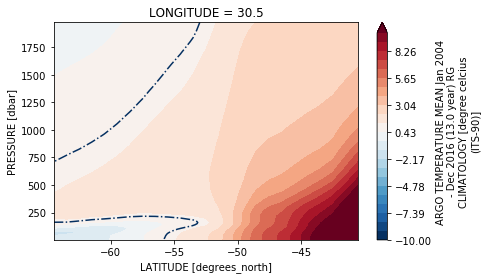

In [22]:
plt.figure(figsize=(15,4))

plt.subplot(121)
RG_clim.ARGO_TEMPERATURE_MEAN.sel(LONGITUDE=30, method='nearest').sel(LATITUDE=slice(-70,-40)
                                                                     ).plot.contourf(vmin=-10, levels=24)
RG_clim.ARGO_TEMPERATURE_MEAN.sel(LONGITUDE=30, method='nearest').sel(LATITUDE=slice(-70,-40)).plot.contour(linestyles='-.',levels=[1])
dens_section.groupby('TIME.month').mean().mean('month').plot.contour(colors='k', levels=7)
dens_section.groupby('TIME.month').mean().mean('month').plot.contour(levels=[27.189, 27.752], colors='C0',
                                                                     linestyles='dashed', linewidths=4)
plt.plot([glider['start_lat'], glider['start_lat']], [4, glider['max_depth']], color='C2', alpha=0.5)
plt.plot([glider['end_lat'], glider['end_lat']], [4, glider['max_depth']], color='C2', alpha=0.5)
plt.gca().invert_yaxis()

plt.subplot(122)
RG_clim.ARGO_SALINITY_MEAN.sel(LONGITUDE=30, method='nearest').sel(LATITUDE=slice(-70,-40)).plot.contourf(vmin=33.77, vmax=35.21, levels=24, cmap=cmocean.cm.haline)
RG_clim.ARGO_SALINITY_MEAN.sel(LONGITUDE=30, method='nearest').sel(LATITUDE=slice(-70,-40)).plot.contour(levels=[34.2], linestyles='dashdot')
dens_section.groupby('TIME.month').mean().mean('month').plot.contour(colors='k', levels=7)
dens_section.groupby('TIME.month').mean().mean('month').plot.contour(levels=[27.189, 27.752], colors='C1', 
                                                                     linestyles='dashed', linewidths=4)
plt.plot([glider['start_lat'], glider['start_lat']], [4, 1900], color='C3', alpha=0.5)

plt.gca().invert_yaxis()

plt.tight_layout()

#plt.savefig('../figures/clim_TS_30E.png')

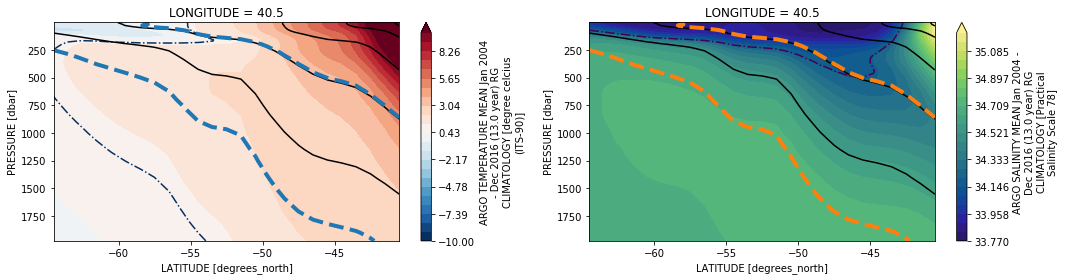

In [329]:
plt.figure(figsize=(15,4))

plt.subplot(121)
RG_clim.ARGO_TEMPERATURE_MEAN.sel(LONGITUDE=40, method='nearest').sel(LATITUDE=slice(-70,-40)
                                                                     ).plot.contourf(vmin=-10,levels=24)
RG_clim.ARGO_TEMPERATURE_MEAN.sel(LONGITUDE=40, method='nearest').sel(LATITUDE=slice(-70,-40)).plot.contour(linestyles='-.',levels=[1])
dens_section40.groupby('TIME.month').mean().mean('month').plot.contour(colors='k', levels=7)
dens_section40.groupby('TIME.month').mean().mean('month').plot.contour(levels=[27.189, 27.752], colors='C0',
                                                                       linestyles='dashed', linewidths=4)
plt.gca().invert_yaxis()

plt.subplot(122)
RG_clim.ARGO_SALINITY_MEAN.sel(LONGITUDE=40, method='nearest').sel(LATITUDE=slice(-70,-40)).plot.contourf(vmin=33.77, vmax=35.21,levels=24, cmap=cmocean.cm.haline)
RG_clim.ARGO_SALINITY_MEAN.sel(LONGITUDE=40, method='nearest').sel(LATITUDE=slice(-70,-40)).plot.contour(levels=[34.2], linestyles='dashdot')
dens_section40.groupby('TIME.month').mean().mean('month').plot.contour(colors='k', levels=7)
dens_section40.groupby('TIME.month').mean().mean('month').plot.contour(levels=[27.189, 27.752], colors='C1', 
                                                                       linestyles='dashed', linewidths=4)

plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('../figures/clim_TS_40E.png')

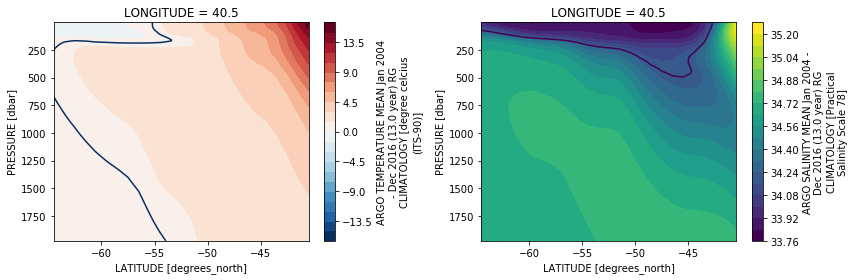

In [251]:
plt.figure(figsize=(12,4))

plt.subplot(121)
RG_clim.ARGO_TEMPERATURE_MEAN.sel(LONGITUDE=40, method='nearest').sel(LATITUDE=slice(-70,-40)).plot.contourf(levels=24)
RG_clim.ARGO_TEMPERATURE_MEAN.sel(LONGITUDE=40, method='nearest').sel(LATITUDE=slice(-70,-40)).plot.contour(levels=[1])
plt.gca().invert_yaxis()

plt.subplot(122)
RG_clim.ARGO_SALINITY_MEAN.sel(LONGITUDE=40, method='nearest').sel(LATITUDE=slice(-70,-40)).plot.contourf(levels=24)
RG_clim.ARGO_SALINITY_MEAN.sel(LONGITUDE=40, method='nearest').sel(LATITUDE=slice(-70,-40)).plot.contour(levels=[34.2])
plt.gca().invert_yaxis()

plt.tight_layout()

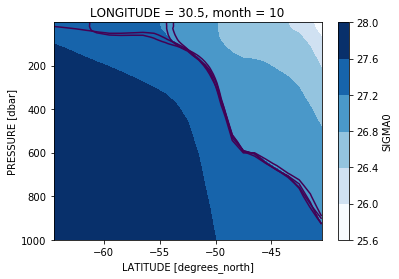

In [345]:
# Not much seasonality below 200m
dens_section.groupby('TIME.month').mean().mean('month').sel(PRESSURE=slice(0,1000)).plot.contourf(cmap='Blues')
dens_section.groupby('TIME.month').mean().isel(month=0).sel(PRESSURE=slice(0,1000)).plot.contour(levels=[27.2])
dens_section.groupby('TIME.month').mean().isel(month=3).sel(PRESSURE=slice(0,1000)).plot.contour(levels=[27.2])
dens_section.groupby('TIME.month').mean().isel(month=6).sel(PRESSURE=slice(0,1000)).plot.contour(levels=[27.2])
dens_section.groupby('TIME.month').mean().isel(month=9).sel(PRESSURE=slice(0,1000)).plot.contour(levels=[27.2])

plt.gca().invert_yaxis()

## N2

\begin{equation}
N^2 = db/dz
\end{equation}

$b = -\frac{g}{\rho_0} \rho'$

$b = g(\alpha \triangle T - \beta \triangle S)$

In [23]:
RG_clim

<xarray.Dataset>
Dimensions:                   (LATITUDE: 145, LONGITUDE: 360, PRESSURE: 58, TIME: 189)
Coordinates:
  * TIME                      (TIME) object 2004-01-16 00:00:00 ... 2019-09-16 00:00:00
  * LONGITUDE                 (LONGITUDE) float32 20.5 21.5 22.5 ... 378.5 379.5
  * LATITUDE                  (LATITUDE) float32 -64.5 -63.5 -62.5 ... 78.5 79.5
  * PRESSURE                  (PRESSURE) float32 2.5 10.0 20.0 ... 1900.0 1975.0
Data variables:
    ARGO_TEMPERATURE_MEAN     (PRESSURE, LATITUDE, LONGITUDE) float32 ...
    ARGO_TEMPERATURE_ANOMALY  (TIME, PRESSURE, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(157, 58, 145, 360), meta=np.ndarray>
    BATHYMETRY_MASK           (PRESSURE, LATITUDE, LONGITUDE) float32 ...
    MAPPING_MASK              (PRESSURE, LATITUDE, LONGITUDE) float32 ...
    ARGO_SALINITY_MEAN        (PRESSURE, LATITUDE, LONGITUDE) float32 ...
    ARGO_SALINITY_ANOMALY     (TIME, PRESSURE, LATITUDE, LONGITUDE) float32 dask.array<chunksize=(157, 58

In [24]:
RG_clim = generate_grid_ds(RG_clim, 
        {'Z':'PRESSURE', 'X':'LONGITUDE', 'Y':'LATITUDE'})

In [25]:
grid = Grid(RG_clim, periodic='X')

In [26]:
g = 9.81
rho0 = 1000

In [27]:
dens_clim_monthly = RG_clim.SIGMA0.groupby('TIME.month').mean()

In [28]:
dens_clim_monthly

<xarray.DataArray 'SIGMA0' (PRESSURE: 58, LATITUDE: 145, LONGITUDE: 360, month: 12)>
dask.array<transpose, shape=(58, 145, 360, 12), dtype=float64, chunksize=(58, 145, 360, 1), chunktype=numpy.ndarray>
Coordinates:
  * LONGITUDE  (LONGITUDE) float32 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
  * LATITUDE   (LATITUDE) float32 -64.5 -63.5 -62.5 -61.5 ... 77.5 78.5 79.5
  * PRESSURE   (PRESSURE) float32 2.5 10.0 20.0 30.0 ... 1800.0 1900.0 1975.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [29]:
N2_clim_monthly = grid.interp(-g/rho0* grid.diff(dens_clim_monthly, 'Z', boundary='extend') / -(grid.diff(RG_clim.PRESSURE, 'Z', boundary='extend')), 'Z', boundary='extend')

In [30]:
N2_clim_monthly_SO = N2_clim_monthly.sel(LATITUDE=slice(-70, -30)).load()

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


In [31]:
N2_clim_monthly_SO = N2_clim_monthly_SO.rename('N2')

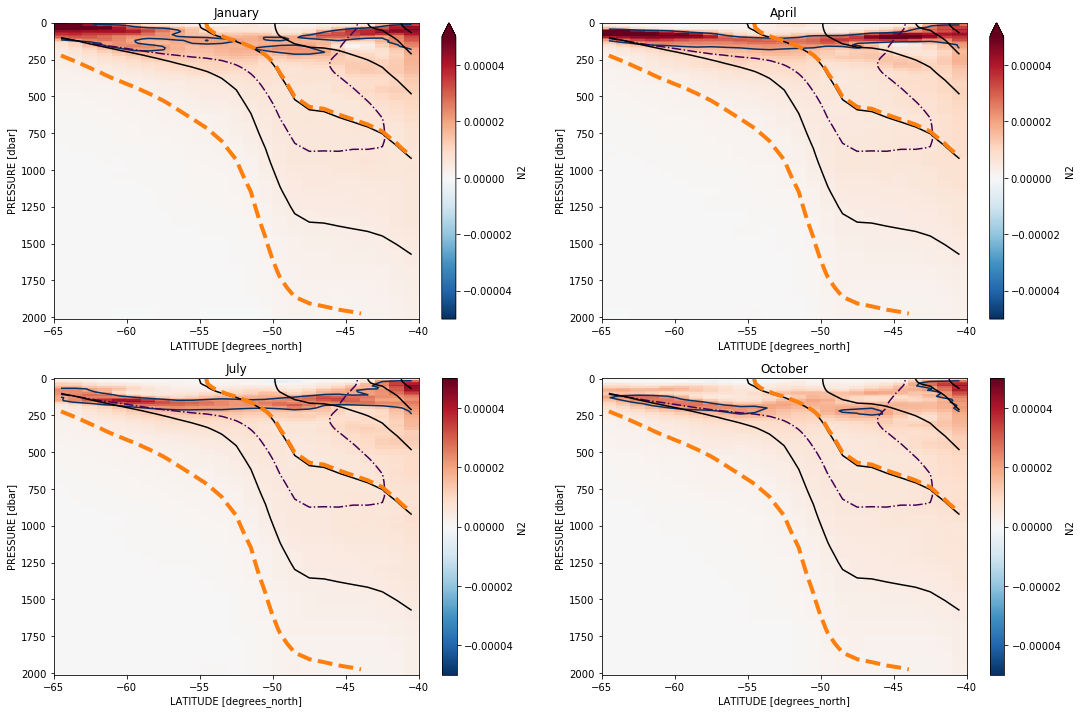

In [451]:
plt.figure(figsize=(18,12))

plt.subplot(221)
N2_clim_monthly_SO.sel(LATITUDE=slice(-70, -40)).sel(LONGITUDE=30, method='nearest').sel(month=1).plot(vmin=-5e-5)
N2_clim_monthly_SO.sel(LATITUDE=slice(-70, -40)).sel(LONGITUDE=30, method='nearest').sel(month=1).plot.contour(levels=[2e-5])
RG_clim.ARGO_SALINITY_MEAN.sel(LONGITUDE=30, method='nearest').sel(
    LATITUDE=slice(-70,-40)).plot.contour(levels=[34.35], linestyles='dashdot')


dens_section30.groupby('TIME.month').mean().mean('month').plot.contour(colors='k', levels=7)
dens_section30.groupby('TIME.month').mean().mean('month').plot.contour(levels=[27.189, 27.752], colors='C1', 
                                                                     linestyles='dashed', linewidths=4)
plt.title('January')
plt.gca().invert_yaxis()

plt.subplot(222)
N2_clim_monthly_SO.sel(LATITUDE=slice(-70, -40)).sel(LONGITUDE=30, method='nearest').sel(month=4).plot(vmin=-5e-5)
N2_clim_monthly_SO.sel(LATITUDE=slice(-70, -40)).sel(LONGITUDE=30, method='nearest').sel(month=4).plot.contour(levels=[2e-5])
RG_clim.ARGO_SALINITY_MEAN.sel(LONGITUDE=30, method='nearest').sel(
    LATITUDE=slice(-70,-40)).plot.contour(levels=[34.35], linestyles='dashdot')

dens_section30.groupby('TIME.month').mean().mean('month').plot.contour(colors='k', levels=7)
dens_section30.groupby('TIME.month').mean().mean('month').plot.contour(levels=[27.189, 27.752], colors='C1', 
                                                                     linestyles='dashed', linewidths=4)
plt.title('April')
plt.gca().invert_yaxis()

plt.subplot(223)
N2_clim_monthly_SO.sel(LATITUDE=slice(-70, -40)).sel(LONGITUDE=30, method='nearest').sel(month=7).plot(vmin=-5e-5)
N2_clim_monthly_SO.sel(LATITUDE=slice(-70, -40)).sel(LONGITUDE=30, method='nearest').sel(month=7).plot.contour(levels=[2e-5])
RG_clim.ARGO_SALINITY_MEAN.sel(LONGITUDE=30, method='nearest').sel(
    LATITUDE=slice(-70,-40)).plot.contour(levels=[34.35], linestyles='dashdot')

dens_section30.groupby('TIME.month').mean().mean('month').plot.contour(colors='k', levels=7)
dens_section30.groupby('TIME.month').mean().mean('month').plot.contour(levels=[27.189, 27.752], colors='C1', 
                                                                     linestyles='dashed', linewidths=4)
plt.title('July')
plt.gca().invert_yaxis()

plt.subplot(224)
N2_clim_monthly_SO.sel(LATITUDE=slice(-70, -40)).sel(LONGITUDE=30, method='nearest').sel(month=10).plot(vmin=-5e-5)
N2_clim_monthly_SO.sel(LATITUDE=slice(-70, -40)).sel(LONGITUDE=30, method='nearest').sel(month=10).plot.contour(levels=[2e-5])
RG_clim.ARGO_SALINITY_MEAN.sel(LONGITUDE=30, method='nearest').sel(
    LATITUDE=slice(-70,-40)).plot.contour(levels=[34.35], linestyles='dashdot')

dens_section30.groupby('TIME.month').mean().mean('month').plot.contour(colors='k', levels=7)
dens_section30.groupby('TIME.month').mean().mean('month').plot.contour(levels=[27.189, 27.752], colors='C1', 
                                                                     linestyles='dashed', linewidths=4)
plt.title('October')
plt.gca().invert_yaxis()

plt.savefig('../figures/clim_N2_30E.png')

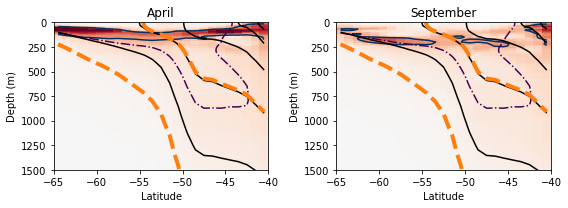

In [49]:
plt.figure(figsize=(8,3))

plt.subplot(121)
#plt.pcolormesh(N2_clim_monthly_SO.LATITUDE.sel(LATITUDE=slice(-70, -40)), 
#               N2_clim_monthly_SO.LATITUDE.sel(=slice(-70, -40)), 
N2_clim_monthly_SO.sel(LATITUDE=slice(-70, -40)).sel(LONGITUDE=30, method='nearest').sel(month=4).plot(vmin=-5e-5,
                                                                                                       rasterized=True,add_colorbar=False)
N2_clim_monthly_SO.sel(LATITUDE=slice(-70, -40)).sel(LONGITUDE=30, method='nearest').sel(month=4).plot.contour(levels=[2e-5])
RG_clim.ARGO_SALINITY_MEAN.sel(LONGITUDE=30, method='nearest').sel(
    LATITUDE=slice(-70,-40)).plot.contour(levels=[34.35], linestyles='dashdot')


dens_section30.groupby('TIME.month').mean().mean('month').plot.contour(colors='k', levels=7)
dens_section30.groupby('TIME.month').mean().mean('month').plot.contour(levels=[27.189, 27.752], colors='C1', 
                                                                     linestyles='dashed', linewidths=4)
plt.title('April')
plt.gca().invert_yaxis()
plt.ylim([1500, 0])
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')

plt.subplot(122)
N2_clim_monthly_SO.sel(LATITUDE=slice(-70, -40)).sel(LONGITUDE=30, method='nearest').sel(month=9).plot(vmin=-5e-5,
                                                                                                       rasterized=True,add_colorbar=False)
N2_clim_monthly_SO.sel(LATITUDE=slice(-70, -40)).sel(LONGITUDE=30, method='nearest').sel(month=9).plot.contour(levels=[2e-5])
RG_clim.ARGO_SALINITY_MEAN.sel(LONGITUDE=30, method='nearest').sel(
    LATITUDE=slice(-70,-40)).plot.contour(levels=[34.35], linestyles='dashdot')

dens_section30.groupby('TIME.month').mean().mean('month').plot.contour(colors='k', levels=7)
dens_section30.groupby('TIME.month').mean().mean('month').plot.contour(levels=[27.189, 27.752], colors='C1', 
                                                                     linestyles='dashed', linewidths=4)
plt.title('September')
plt.gca().invert_yaxis()
plt.ylim([1500, 0])
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')

plt.tight_layout()
plt.savefig('N2_climatology.pdf')

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


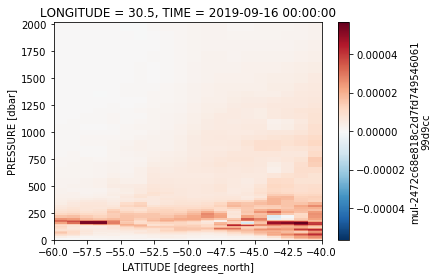

In [407]:
N2.sel(LATITUDE=slice(-60, -40)).sel(LONGITUDE=30, method='nearest').isel(TIME=-1).plot()

The apply ufunc way, not working yet. 

In [364]:
CT_clim = CT.groupby('TIME.month').mean()
SA_clim = SA.groupby('TIME.month').mean()

In [366]:
CT_clim_region = CT_clim.sel(LATITUDE=slice(-65,-35), LONGITUDE=slice(20,50)).load()
SA_clim_region = SA_clim.sel(LATITUDE=slice(-65,-35), LONGITUDE=slice(20,50)).load()

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [373]:
(N2, pmid) = xr.apply_ufunc(gsw.Nsquared, SA_clim_region, CT_clim_region, RG_clim.PRESSURE, 
                            dask='parallelized', 
                            input_core_dims=[['PRESSURE'],['PRESSURE'],['PRESSURE']],
                            output_core_dims=[['PRESSURE'],['PRESSURE']], exclude_dims=set(['PRESSURE']))

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/gsw/stability.py:85: RuntimeWarning: divide by zero encountered in true_divide
  N2 = ((g_local**2) / (specvol_mid * db_to_pa * dp))


ValueError: size of dimension 'LATITUDE' on inputs was unexpectedly changed by applied function from 30 to 29. Only dimensions specified in ``exclude_dims`` with xarray.apply_ufunc are allowed to change size.

### Gestrophic Velocities

In [284]:
psi = xr.apply_ufunc(gsw.geo_strf_dyn_height, SA, CT , RG_clim.PRESSURE, 
                    dask='parallelized', output_dtypes=[float,]).rename('psi')

In [285]:
psi

<xarray.DataArray 'psi' (PRESSURE: 58, LATITUDE: 145, LONGITUDE: 360, TIME: 189)>
dask.array<geo_strf_dyn_height, shape=(58, 145, 360, 189), dtype=float64, chunksize=(58, 145, 360, 157), chunktype=numpy.ndarray>
Coordinates:
  * LONGITUDE  (LONGITUDE) float32 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
  * LATITUDE   (LATITUDE) float32 -64.5 -63.5 -62.5 -61.5 ... 77.5 78.5 79.5
  * PRESSURE   (PRESSURE) float32 2.5 10.0 20.0 30.0 ... 1800.0 1900.0 1975.0
  * TIME       (TIME) float64 0.5 1.5 2.5 3.5 4.5 ... 185.5 186.5 187.5 188.5

In [294]:
vels = xr.apply_ufunc(gsw.geostrophic_velocity, psi, psi.LONGITUDE, psi.LATITUDE, 
                     dask='parallelized', output_core_dims=[4,4], output_dtypes=[float,]).rename('vels')

TypeError: 'int' object is not iterable

In [292]:
vels

<xarray.DataArray 'vels' (PRESSURE: 58, LATITUDE: 145, LONGITUDE: 360, TIME: 189)>
dask.array<geostrophic_velocity, shape=(58, 145, 360, 189), dtype=float64, chunksize=(58, 145, 360, 157), chunktype=numpy.ndarray>
Coordinates:
  * LONGITUDE  (LONGITUDE) float32 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
  * LATITUDE   (LATITUDE) float32 -64.5 -63.5 -62.5 -61.5 ... 77.5 78.5 79.5
  * PRESSURE   (PRESSURE) float32 2.5 10.0 20.0 30.0 ... 1800.0 1900.0 1975.0
  * TIME       (TIME) float64 0.5 1.5 2.5 3.5 4.5 ... 185.5 186.5 187.5 188.5

### Mixed Layer Depth

Ended up going with Holte's climatology for MLD work 

In [162]:
delta_dens = RG_clim.SIGMA0 - RG_clim.SIGMA0.isel(PRESSURE=0)

In [168]:
import nc_time_axis

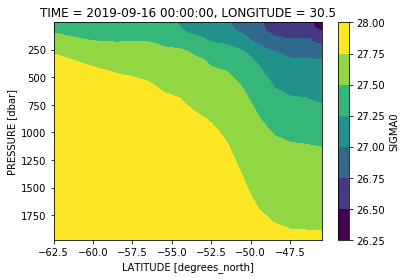

In [177]:
RG_clim.SIGMA0.sel(LONGITUDE=30, method='nearest').sel( LATITUDE=slice(-63,-45)).isel(TIME=-1).plot.contourf()
plt.gca().invert_yaxis()

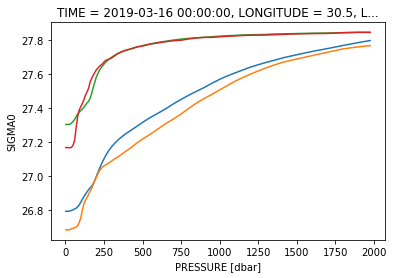

In [174]:
RG_clim.SIGMA0.sel(LONGITUDE=30, LATITUDE=-50, method='nearest').isel(TIME=-1).plot()
RG_clim.SIGMA0.sel(LONGITUDE=30, LATITUDE=-50, method='nearest').isel(TIME=-7).plot()
RG_clim.SIGMA0.sel(LONGITUDE=30, LATITUDE=-60, method='nearest').isel(TIME=-1).plot()
RG_clim.SIGMA0.sel(LONGITUDE=30, LATITUDE=-60, method='nearest').isel(TIME=-7).plot()

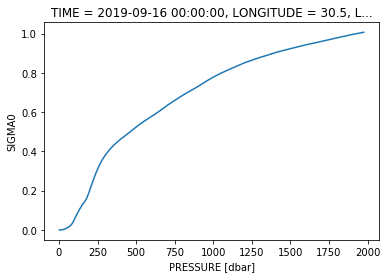

In [178]:
delta_dens.sel(LONGITUDE=30, LATITUDE=-50, method='nearest').isel(TIME=-1).plot()

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


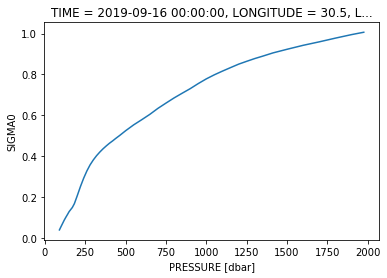

In [179]:
temp = delta_dens.where(delta_dens>0.03).sel(LONGITUDE=30, LATITUDE=-50, method='nearest').isel(TIME=-1).plot()

In [191]:
temp = delta_dens.where(delta_dens>0.03)

In [192]:
MLD = temp.PRESSURE.where(temp == temp.min('PRESSURE')).min('PRESSURE')

In [198]:
MLD_clim = temp.PRESSURE.where(temp == temp.min('PRESSURE')).min('PRESSURE').groupby('TIME.month').mean()

In [207]:
MLD_clim.load()

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'PRESSURE' (LATITUDE: 145, LONGITUDE: 360, month: 12)>
array([[[20.      , 30.      , 38.125   , ..., 82.      , 62.666668,
         32.      ],
        [20.      , 30.      , 36.875   , ..., 83.333336, 64.666664,
         28.666666],
        [19.375   , 30.      , 35.      , ..., 83.333336, 65.333336,
         28.666666],
        ...,
        [20.625   , 30.      , 38.75    , ..., 75.333336, 61.333332,
         27.333334],
        [20.625   , 30.      , 38.75    , ..., 76.666664, 61.333332,
         31.333334],
        [20.      , 30.      , 38.75    , ..., 80.      , 62.      ,
         36.      ]],

       [[21.25    , 31.25    , 38.125   , ..., 80.      , 52.666668,
         37.333332],
        [21.25    , 31.25    , 38.125   , ..., 82.      , 55.333332,
         33.333332],
        [21.25    , 30.625   , 38.75    , ..., 82.      , 64.666664,
         32.      ],
        ...,
        [22.5     , 30.      , 38.75    , ..., 82.      , 60.      ,
         33.333332],

In [222]:
MLD_clim.month

<xarray.DataArray 'month' (month: 12)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

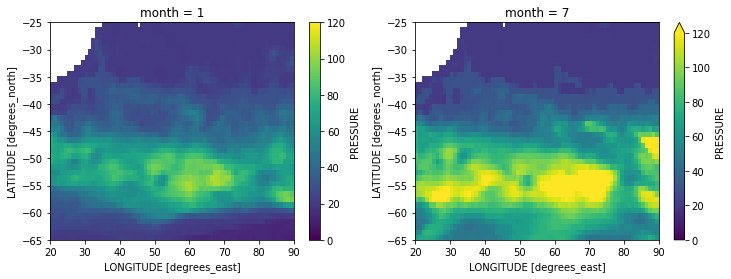

In [225]:
plt.figure(figsize=(12,4))

plt.subplot(121)
MLD_clim.sel(LATITUDE=slice(-75,-25), LONGITUDE=slice(20,90)).sel(month=1).plot(vmin=0, vmax=120)

plt.subplot(122)
MLD_clim.sel(LATITUDE=slice(-75,-25), LONGITUDE=slice(20,90)).sel(month=7).plot(vmin=0, vmax=120)

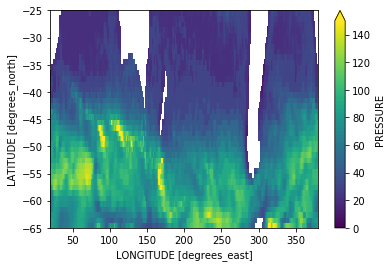

In [234]:
MLD_clim.max('month').sel(LATITUDE=slice(-75,-25), LONGITUDE=slice(20,380)).plot(vmin=0, vmax=150)

In [226]:
deltaH = MLD_clim.max('month') - MLD_clim.min('month')

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


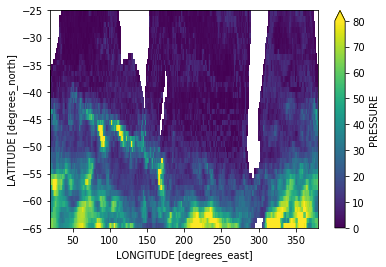

In [231]:
deltaH.sel(LATITUDE=slice(-75,-25), LONGITUDE=slice(20,380)).plot(vmin=0, vmax=80)

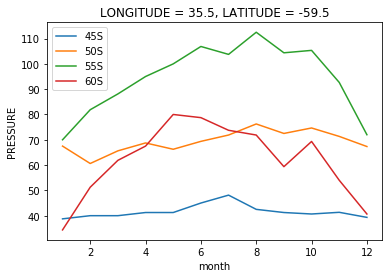

In [214]:
MLD_clim.sel(LATITUDE=-45, LONGITUDE=35, method='nearest').plot(label='45S')
MLD_clim.sel(LATITUDE=-50, LONGITUDE=35, method='nearest').plot(label='50S')
MLD_clim.sel(LATITUDE=-55, LONGITUDE=35, method='nearest').plot(label='55S')
MLD_clim.sel(LATITUDE=-60, LONGITUDE=35, method='nearest').plot(label='60S')
plt.legend()

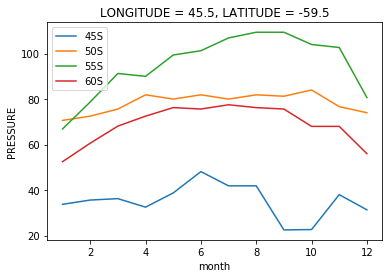

In [215]:
MLD_clim.sel(LATITUDE=-45, LONGITUDE=45, method='nearest').plot(label='45S')
MLD_clim.sel(LATITUDE=-50, LONGITUDE=45, method='nearest').plot(label='50S')
MLD_clim.sel(LATITUDE=-55, LONGITUDE=45, method='nearest').plot(label='55S')
MLD_clim.sel(LATITUDE=-60, LONGITUDE=45, method='nearest').plot(label='60S')
plt.legend()